<a href="https://colab.research.google.com/github/KGYAMFI22/csv-leaflet-map/blob/main/Burn_Severity_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.5 MB/s eta 0:00:00


In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Improved Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 images (pre-fire and post-fire) and mask clouds
s2_collection_pre_fire = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2021-12-01', '2022-01-15')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

s2_collection_post_fire = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-16', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Calculate dNBR
nbr_pre = s2_collection_pre_fire.normalizedDifference(['B8', 'B12']).rename('NBR_PreFire')
nbr_post = s2_collection_post_fire.normalizedDifference(['B8', 'B12']).rename('NBR_PostFire')
dnbr = nbr_pre.subtract(nbr_post).rename('dNBR')

# Step 4: Calculate MNDWI and SAVI for burn severity refinement
mndwi = s2_collection_pre_fire.normalizedDifference(['B3', 'B11']).rename('MNDWI')
savi = s2_collection_pre_fire.expression(
    '(NIR - RED) / (NIR + RED + L) * (1 + L)', {
        'NIR': s2_collection_pre_fire.select('B8'),
        'RED': s2_collection_pre_fire.select('B4'),
        'L': 0.5  # Soil adjustment factor
    }
).rename('SAVI')

# Step 5: Apply threshold-based burn severity classification
burn_scar_mask = dnbr.gte(0.27).And(mndwi.lte(0.4)).And(savi.lte(0.4))

# Step 6: Visualize results using Geemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# Add the dNBR layer (classification-based visualization)
dnbr_vis_params = {'min': -0.5, 'max': 1.0, 'palette': ['blue', 'white', 'red']}
map1.addLayer(dnbr, dnbr_vis_params, 'dNBR')

# Add burn scar mask layer with refined thresholds
map1.addLayer(burn_scar_mask.updateMask(burn_scar_mask), {'palette': ['black']}, 'Final Burn Scar')

# Legend
legend_dict = {
    'Severe Burn': '#ff0000',  # Red for severe
    'Moderate Burn': '#ff8800',  # Orange for moderate
    'Low Burn': '#ffff00',  # Yellow for low
    'No Burn': '#0000ff'  # Blue for no burn
}

map1.add_legend(
    title='Burn Severity Legend',
    legend_dict=legend_dict,
    position='bottomright'
)

# Display the map with layer control
map1.addLayerControl()
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

ติดต่ออาจาร


In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Compute NDVI (Normalized Difference Vegetation Index)
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 4: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 5: Convert Masked Plants to Objects for Counting
plant_objects = plant_mask.selfMask().connectedComponents(
    connectivity=8, maxSize=128  # 8-connectivity for better segmentation
)

# Extract unique plant count
plant_count = plant_objects.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,  # Sentinel-2 resolution
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 6: Visualization
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# NDVI Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Plant Mask Visualization
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

# Display the map
map1.addLayerControl()
map1


TypeError: Image.connectedComponents() got an unexpected keyword argument 'connectivity'

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Compute NDVI (Normalized Difference Vegetation Index)
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 4: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 5: Label Plant Patches using Connected Components
plant_objects = plant_mask.selfMask().connectedComponents(
    connectivity=ee.Kernel.plus(1), maxSize=128
)

# Extract Unique Plant Cluster Count
plant_count = plant_objects.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,  # Sentinel-2 resolution
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 6: Visualization
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# NDVI Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Plant Mask Visualization
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

# Display the map
map1.addLayerControl()
map1


TypeError: Image.connectedComponents() got an unexpected keyword argument 'connectivity'

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Compute NDVI (Normalized Difference Vegetation Index)
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 4: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 5: Label Plant Patches using Connected Components
plant_objects = plant_mask.selfMask().connectedComponents(
    connectivity=ee.Kernel.plus(1), maxSize=128
)

# Extract Unique Plant Cluster Count
plant_count = plant_objects.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,  # Sentinel-2 resolution
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 6: Visualization
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# NDVI Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Plant Mask Visualization
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

# Display the map
map1.addLayerControl()
map1


TypeError: Image.connectedComponents() got an unexpected keyword argument 'connectivity'

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Compute NDVI (Normalized Difference Vegetation Index)
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 4: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 5: Use reduceConnectedComponents() to Label Plant Patches
plant_clusters = plant_mask.selfMask().connectedComponents(
    {'connectedness': ee.Kernel.plus(1), 'maxSize': 128}
)

# Step 6: Count the Unique Plant Clusters
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,  # Sentinel-2 resolution
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 7: Visualization
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# NDVI Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Plant Mask Visualization
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

# Display the map
map1.addLayerControl()
map1


TypeError: Image.connectedComponents() missing 1 required positional argument: 'maxSize'

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Define the area of interest
boundary = ee.Geometry.Polygon([
    [
        [100.08846791757806, 15.690328128622575],
        [100.14202626718743, 15.690328128622575],
        [100.14202626718743, 15.732301072397595],
        [100.08846791757806, 15.732301072397595],
        [100.08846791757806, 15.690328128622575]
    ]
])

# Cloud Masking Function using SCL band
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 2: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 3: Compute NDVI (Normalized Difference Vegetation Index)
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 4: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 5: Use Connected Components to Label Plant Patches
plant_clusters = plant_mask.selfMask().connectedComponents(ee.Kernel.plus(1), 128)

# Step 6: Count the Unique Plant Clusters
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,  # Sentinel-2 resolution
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 7: Visualization
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)

# NDVI Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Plant Mask Visualization
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

# Display the map
map1.addLayerControl()
map1


Estimated Plant Count: {'labels': 1458}


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()  # Enable draw tools for user selection

# Function to get the drawn feature
def get_drawing(feature):
    global boundary
    boundary = feature.geometry()  # Get geometry from drawn rectangle
    print("New AOI Selected:", boundary.getInfo())

# Capture drawn features
map1.on_draw_feature(get_drawing)

# Display the interactive map
map1


AttributeError: 'Map' object has no attribute 'on_draw_feature'

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map with drawing tools
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()

# Display the interactive map
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Step 3: Get the User-Drawn Area
boundary = map1.user_roi
if boundary is None:
    raise ValueError("No region selected! Please draw a rectangle on the map and try again.")

# Step 4: Cloud Masking Function
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 5: Load Sentinel-2 image
s2_image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2022-01-01', '2022-02-28')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .filterBounds(boundary)
    .map(mask_s2clouds)
    .median()
)

# Step 6: Compute NDVI
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 7: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 8: Connected Components to Label Plant Patches
plant_clusters = plant_mask.selfMask().connectedComponents(ee.Kernel.plus(1), 128)

# Step 9: Count the Unique Plant Clusters
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 10: Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

map1


In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map with a Satellite basemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.add_basemap("SATELLITE")  # Set Google Satellite as the background
map1.addLayerControl()
map1.add_draw_control()

# Display the interactive map
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Step 3: Get the User-Drawn Area
boundary = map1.user_roi
if boundary is None:
    raise ValueError("No region selected! Please draw a rectangle on the map and try again.")

# Step 4: Cloud Masking Function
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Step 5: Get the Most Recent Sentinel-2 Image
s2_latest = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(boundary)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .sort('system:time_start', False)  # Sort by date (most recent first)
    .first()  # Select the latest image
)

# Step 6: Compute NDVI
ndvi = s2_latest.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 7: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 8: Connected Components to Label Plant Patches
plant_clusters = plant_mask.selfMask().connectedComponents(ee.Kernel.plus(1), 128)

# Step 9: Count the Unique Plant Clusters
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 10: Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}  # True-color

map1.addLayer(s2_latest, rgb_vis, "Latest Sentinel-2 True Color")  # Add latest true-color image
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

map1


Estimated Plant Count: {'labels': 1}


Map(bottom=31130689.0, center=[12.893363406413188, 101.700208932869], controls=(WidgetControl(options=['positi…

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map with Satellite Imagery
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()

# Set the map to display Google Satellite view
map1.add_basemap('SATELLITE')

# Display the interactive map
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Step 3: Get the User-Drawn Area
boundary = map1.user_roi
if boundary is None:
    raise ValueError("No region selected! Please draw a rectangle on the map and try again.")

# Step 4: Get the Most Recent Sentinel-2 Image
s2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(boundary)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .sort('system:time_start', False)  # Sort by date (latest first)
)

latest_image = s2_collection.first()  # Select the most recent image

# Step 5: Cloud Masking Function
def mask_s2clouds(image):
    scl = image.select('SCL')
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))  # Cloud, Cirrus, Shadows
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Apply cloud masking
s2_image = mask_s2clouds(latest_image)

# Step 6: Compute NDVI
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 7: Threshold NDVI to Detect Plants
plant_mask = ndvi.gte(0.3)  # Adjust threshold based on vegetation type

# Step 8: Connected Components to Label Plant Patches
plant_clusters = plant_mask.selfMask().connectedComponents(ee.Kernel.plus(1), 128)

# Step 9: Count the Unique Plant Clusters
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,
    maxPixels=1e9
)

# Print Plant Count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 10: Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(s2_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Latest Sentinel-2 Image')
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')

map1


Estimated Plant Count: {'labels': 1}


Map(bottom=15565512.0, center=[12.893180385563953, 101.70033235219921], controls=(WidgetControl(options=['posi…

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map with a satellite basemap and drawing tools
map1 = geemap.Map(center=[15.7, 100.1], zoom=12, basemap='SATELLITE')
map1.addLayerControl()
map1.add_draw_control()  # Enable drawing tools for interactive AOI selection

# Display the interactive map
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map with satellite imagery
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()

# Set the map to display a satellite basemap
map1.add_basemap('SATELLITE')

# Display the interactive map
map1


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:

# Step 3: Get the user-drawn area (ROI)
boundary = map1.user_roi
if boundary is None:
    raise ValueError("No region selected! Please draw a rectangle on the map and try again.")

# Step 4: Retrieve the most recent Sentinel-2 image from the collection
s2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(boundary)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .sort('system:time_start', False)  # Sort by date (latest first)
)

latest_image = s2_collection.first()  # Select the latest image

# Step 5: Define a cloud masking function for Sentinel-2
def mask_s2clouds(image):
    scl = image.select('SCL')
    # Remove clouds, cirrus, and shadows
    cloud_mask = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))
    return image.updateMask(cloud_mask.Not()).divide(10000)

# Apply cloud masking to the latest image
s2_image = mask_s2clouds(latest_image)

# Step 6: Compute NDVI using the NIR (B8) and Red (B4) bands
ndvi = s2_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 7: Threshold NDVI to detect vegetation (adjust the threshold as needed)
plant_mask = ndvi.gte(0.3)

# Step 8: Use connected components to label individual plant patches
plant_clusters = plant_mask.selfMask().connectedComponents(ee.Kernel.plus(1), 128)

# Step 9: Count unique plant clusters within the ROI
plant_count = plant_clusters.select('labels').reduceRegion(
    reducer=ee.Reducer.countDistinct(),
    geometry=boundary,
    scale=10,
    maxPixels=1e9
)

# Output the estimated plant count
print("Estimated Plant Count:", plant_count.getInfo())

# Step 10: Visualization
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['brown', 'yellow', 'green']}
map1.addLayer(s2_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Latest Sentinel-2 Image')
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')
map1.addLayer(plant_mask.updateMask(plant_mask), {'palette': ['green']}, 'Detected Plants')
map1


Estimated Plant Count: {'labels': 1}


Map(bottom=15565426.0, center=[12.894079801021599, 101.70427018933059], controls=(WidgetControl(options=['posi…

In [ ]:
import ee
import geemap

# Step 1: Authenticate and initialize Earth Engine
ee.Authenticate()  # Follow the on-screen instructions
ee.Initialize(project='ee-sahacstu')

# Step 2: Create an interactive map
Map = geemap.Map(center=[15.7, 100.1], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayerControl()
Map.add_draw_control()

# Step 3: Define your region of interest (ROI)
# For demonstration, we'll use a drawn polygon or a manually specified geometry.
# You can draw an ROI on the map or specify a geometry directly.
# Example: region = ee.Geometry.Rectangle([100.0, 15.6, 100.2, 15.8])  # [xmin, ymin, xmax, ymax]

# If you want to draw your ROI on the map, uncomment the next line after drawing:
# region = Map.user_roi  # If you used the draw control to create a polygon

# Step 4: Load a satellite image collection
# Example: Using Sentinel-2 Surface Reflectance data
# (You could also use Landsat 8/9, but Sentinel-2 has higher resolution)
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(Map.user_roi)   # or your region
              .filterDate('2022-01-01', '2022-12-31')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

# Take a median composite to reduce cloud artifacts
image = collection.median()

# Step 5: Compute NDVI
# NDVI = (NIR - Red) / (NIR + Red)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Step 6: Threshold the NDVI to create a vegetation mask
# Adjust threshold based on your region and the vegetation type
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# Step 7: (Optional) Morphological filtering to remove noise
# This example uses a focal operation to reduce small patches
# Increase 'radius' or use 'dilate/erode' as needed
filtered_mask = tree_mask.focal_max(radius=1)

# Step 8: Convert the mask to vectors (polygons) representing tree canopies
tree_vectors = filtered_mask.reduceToVectors(
    geometry=Map.user_roi,        # or your region
    scale=10,                     # Sentinel-2 resolution is ~10m
    geometryType='polygon',
    labelProperty='tree',
    eightConnected=False,
    maxPixels=1e13
)

# Step 9: Count the number of distinct polygons
tree_count = tree_vectors.size()

# Step 10: Print results
print('Estimated number of tree polygons:', tree_count.getInfo())

# Step 11: Add layers to the map for visualization
# Visualize NDVI
ndvi_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
Map.addLayer(ndvi, ndvi_params, 'NDVI')

# Visualize tree mask
mask_vis_params = {'palette': ['brown']}
Map.addLayer(filtered_mask.selfMask(), mask_vis_params, 'Tree Mask')

# Visualize polygons
Map.addLayer(tree_vectors, {}, 'Tree Polygons')

# Display the interactive map
Map


EEException: Image.normalizedDifference: No band named 'B8'. Available band names: [].

In [ ]:
import ee
import geemap
import datetime

# -------------------------------------------------------------
# Step 1: Authenticate and initialize Earth Engine
# -------------------------------------------------------------
ee.Authenticate()  # ทำตามขั้นตอนบน Colab เพื่ออนุญาตให้ใช้ GEE
ee.Initialize(project='ee-sahacstu')

# -------------------------------------------------------------
# Step 2: Create an interactive map
# -------------------------------------------------------------
Map = geemap.Map(center=[15.7, 100.1], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayerControl()
Map.add_draw_control()

# -------------------------------------------------------------
# Step 3: Define your region of interest (ROI)
# -------------------------------------------------------------
# (1) ใช้ geometry แบบกำหนดเอง เช่น Rectangle
#region = ee.Geometry.Rectangle([100.0, 15.6, 100.2, 15.8])

# (2) หรือใช้ ROI ที่วาดบน Map
region = Map.user_roi  # หากใช้ draw_control วาด polygon

Map


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Step 4: Define date range for the LAST 30 DAYS
# -------------------------------------------------------------
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print("Start date:", start_str)
print("End date:", end_str)

# -------------------------------------------------------------
# Step 5: Load a satellite image collection (Sentinel-2 SR)
# -------------------------------------------------------------
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

# ตรวจสอบขนาด collection
collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)

# หาก collection_size = 0 อาจต้องขยายวันที่หรือลดเงื่อนไขเมฆ
if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. "
                     "Try adjusting the date range or cloud filter.")

# -------------------------------------------------------------
# Step 6: Create a median composite
# -------------------------------------------------------------
image = collection.median()

# -------------------------------------------------------------
# Step 7: Compute NDVI = (NIR - RED) / (NIR + RED)
# -------------------------------------------------------------
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# -------------------------------------------------------------
# Step 8: Threshold the NDVI to create a vegetation mask
# -------------------------------------------------------------
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# -------------------------------------------------------------
# Step 9: (Optional) Morphological filtering
# -------------------------------------------------------------
# focal_max(radius=1) ช่วยขยายบริเวณ NDVI ที่สูง เพื่อรวมจุดที่ขาดเล็กน้อย
filtered_mask = tree_mask.focal_max(radius=1)

# -------------------------------------------------------------
# Step 10: Convert the mask to vectors (polygons)
# -------------------------------------------------------------
tree_vectors = filtered_mask.reduceToVectors(
    geometry=region,
    scale=10,                     # Sentinel-2 resolution ~10m
    geometryType='polygon',
    labelProperty='tree',
    eightConnected=False,
    maxPixels=1e13
)

# -------------------------------------------------------------
# Step 11: Count the number of distinct polygons
# -------------------------------------------------------------
tree_count = tree_vectors.size()
print('Estimated number of tree polygons:', tree_count.getInfo())

# -------------------------------------------------------------
# Step 12: Add layers to the map for visualization
# -------------------------------------------------------------
# 12.1 Visualize NDVI
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
Map.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# 12.2 Visualize the filtered tree mask
mask_vis_params = {'palette': ['brown']}
Map.addLayer(filtered_mask.selfMask(), mask_vis_params, 'Tree Mask')

# 12.3 Visualize the vector polygons
Map.addLayer(tree_vectors, {}, 'Tree Polygons')

# -------------------------------------------------------------
# Step 13: Display the interactive map
# -------------------------------------------------------------
Map

Start date: 2025-02-04
End date: 2025-03-06
Collection size (30 days): 0


ValueError: No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.

In [ ]:
import ee
import geemap
import datetime

# -------------------------------------------------------------
# Step 1: Authenticate and initialize Earth Engine
# -------------------------------------------------------------
ee.Authenticate()  # ทำตามขั้นตอนบน Colab เพื่ออนุญาตให้ใช้ GEE
ee.Initialize(project='ee-sahacstu')

# -------------------------------------------------------------
# Step 2: Create an interactive map with draw control for ROI
# -------------------------------------------------------------
Map = geemap.Map(center=[15.7, 100.1], zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayerControl()
Map.add_draw_control()

# Note: Draw a polygon on the map to set the ROI.
# The ROI will be accessed as Map.user_roi.
# To test without drawing, you can uncomment the following line:
# Map.user_roi = ee.Geometry.Rectangle([100.0, 15.6, 100.2, 15.8])

# -------------------------------------------------------------
# Step 3: Use ROI from the drawn polygon on the Map
# -------------------------------------------------------------
region = Map.user_roi  # ใช้ ROI ที่วาดบน Map

# -------------------------------------------------------------
# Step 4: Define date range for the LAST 30 DAYS
# -------------------------------------------------------------
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=90)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print("Start date:", start_str)
print("End date:", end_str)

# -------------------------------------------------------------
# Step 5: Load a satellite image collection (Sentinel-2 SR)
# -------------------------------------------------------------
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

# ตรวจสอบขนาด collection
collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)

if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. "
                     "Try adjusting the date range or cloud filter.")

# -------------------------------------------------------------
# Step 6: Create a median composite to reduce clouds/noise
# -------------------------------------------------------------
image = collection.median()

# -------------------------------------------------------------
# Step 7: Compute NDVI = (NIR - RED) / (NIR + RED)
# -------------------------------------------------------------
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# -------------------------------------------------------------
# Step 8: Threshold the NDVI to create a vegetation (tree) mask
# -------------------------------------------------------------
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# -------------------------------------------------------------
# Step 9: (Optional) Morphological filtering to smooth the mask
# -------------------------------------------------------------
filtered_mask = tree_mask.focal_max(radius=1)

# -------------------------------------------------------------
# Step 10: Convert the mask to vectors (polygons)
# -------------------------------------------------------------
tree_vectors = filtered_mask.reduceToVectors(
    geometry=region,
    scale=10,                     # Sentinel-2 resolution ~10m
    geometryType='polygon',
    labelProperty='tree',
    eightConnected=False,
    maxPixels=1e13
)

# -------------------------------------------------------------
# Step 11: Count the number of distinct tree polygons
# -------------------------------------------------------------
tree_count = tree_vectors.size()
print('Estimated number of tree polygons:', tree_count.getInfo())

# -------------------------------------------------------------
# Step 12: Add layers to the map for visualization
# -------------------------------------------------------------
# Visualize NDVI
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
Map.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Visualize the filtered tree mask
mask_vis_params = {'palette': ['brown']}
Map.addLayer(filtered_mask.selfMask(), mask_vis_params, 'Tree Mask')

# Visualize the vector polygons for trees
Map.addLayer(tree_vectors, {}, 'Tree Polygons')

# -------------------------------------------------------------
# Step 13: Display the interactive map
# -------------------------------------------------------------
Map


Start date: 2024-12-06
End date: 2025-03-06
Collection size (30 days): 0


ValueError: No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.

In [ ]:
import ee
import geemap
import datetime

# -------------------------------------------------------------
# Step 1: Authenticate and initialize Earth Engine
# -------------------------------------------------------------
ee.Authenticate()  # ทำตามขั้นตอนบน Colab เพื่ออนุญาตการใช้งาน GEE
ee.Initialize(project='ee-sahacstu')

# -------------------------------------------------------------
# Step 2: Create an interactive map with satellite imagery and draw control
# -------------------------------------------------------------
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()  # ให้คุณวาด ROI บนแผนที่ด้วยเครื่องมือ draw control
map1.add_basemap('SATELLITE')

# Display the interactive map
map1




Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
region = map1.user_roi
if region is None:
    raise ValueError("No ROI drawn on the map. Please draw a polygon using the draw control.")

# -------------------------------------------------------------
# Step 4: Define the date range for the LAST 30 DAYS
# -------------------------------------------------------------
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

print("Start date:", start_str)
print("End date:", end_str)

# -------------------------------------------------------------
# Step 5: Load the Sentinel-2 Surface Reflectance image collection
# -------------------------------------------------------------
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)

if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.")

# -------------------------------------------------------------
# Step 6: Create a median composite image to reduce noise and clouds
# -------------------------------------------------------------
image = collection.median()

# -------------------------------------------------------------
# Step 7: Compute NDVI (Normalized Difference Vegetation Index)
# -------------------------------------------------------------
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# -------------------------------------------------------------
# Step 8: Threshold NDVI to create a vegetation (tree) mask
# -------------------------------------------------------------
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# -------------------------------------------------------------
# Step 9: Apply morphological filtering to smooth the mask (optional)
# -------------------------------------------------------------
filtered_mask = tree_mask.focal_max(radius=1)

# -------------------------------------------------------------
# Step 10: Convert the mask to vector polygons (each polygon approximates a tree or tree cluster)
# -------------------------------------------------------------
tree_vectors = filtered_mask.reduceToVectors(
    geometry=region,
    scale=10,                     # Sentinel-2 resolution ~10m
    geometryType='polygon',
    labelProperty='tree',
    eightConnected=False,
    maxPixels=1e13
)

# -------------------------------------------------------------
# Step 11: Count the number of tree polygons
# -------------------------------------------------------------
tree_count = tree_vectors.size().getInfo()
print('Estimated number of tree polygons:', tree_count)

# -------------------------------------------------------------
# Step 12: Add layers to the map for visualization
# -------------------------------------------------------------
# Visualize NDVI layer
ndvi_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
map1.addLayer(ndvi, ndvi_vis_params, 'NDVI')

# Visualize the filtered tree mask
mask_vis_params = {'palette': ['brown']}
map1.addLayer(filtered_mask.selfMask(), mask_vis_params, 'Tree Mask')

# Visualize the vector polygons outlining trees
map1.addLayer(tree_vectors, {}, 'Tree Polygons')

# Display the map again with the new layers
map1

Start date: 2025-02-04
End date: 2025-03-06
Collection size (30 days): 1
Estimated number of tree polygons: 1


Map(bottom=31130748.0, center=[12.893054803769896, 101.69997920541356], controls=(WidgetControl(options=['posi…

In [ ]:
# --- Earth Engine & geemap Setup ---
import ee
import geemap
import datetime

# Authenticate and initialize Earth Engine
ee.Authenticate()  # ทำตามขั้นตอนเพื่ออนุญาต GEE
ee.Initialize(project='ee-sahacstu')

# Create an interactive map with draw control
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()  # ใช้วาด ROI บนแผนที่
map1.add_basemap('SATELLITE')
display(map1)  # ใน Colab ให้แสดง map ด้วย display()

# รอให้ผู้ใช้วาด ROI บน map1 จาก draw control



Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
 # Use ROI from drawn polygon
region = map1.user_roi

# Define date range for the last 30 days
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
print("Start date:", start_str)
print("End date:", end_str)

# Load Sentinel-2 Surface Reflectance image collection within ROI and date range
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)
if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.")

# Create a median composite image to reduce noise and clouds
image = collection.median()

# Compute NDVI: (NIR - RED) / (NIR + RED)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Threshold NDVI to create a binary vegetation (tree) mask (threshold can be tuned)
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# Apply morphological filtering to smooth the mask (optional)
filtered_mask = tree_mask.focal_max(radius=1)

# --- Export the Mask to a NumPy Array ---
# Convert the filtered mask from EE to a numpy array using geemap.ee_to_numpy
# Note: Adjust 'scale' to match desired resolution. Sentinel-2 resolution is ~10m.
mask_array, mask_geotransform = geemap.ee_to_numpy(
    filtered_mask,
    region=region,
    scale=10,
    return_geotransform=True
)

# Normalize mask_array: ensure binary (0 or 255) for segmentation
import numpy as np
mask_array = (mask_array > 0.5).astype(np.uint8) * 255

# --- Watershed Segmentation using OpenCV and skimage ---
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

# Compute the distance transform of the binary mask
distance = cv2.distanceTransform(mask_array, cv2.DIST_L2, 5)

# Find local maxima as markers for watershed, adjust min_distance as needed
localMax = peak_local_max(distance, indices=False, min_distance=20, labels=mask_array)

# Label the markers
markers = cv2.connectedComponents(np.uint8(localMax))[1]

# Apply the watershed algorithm; use negative distance so that peaks become basins
labels = watershed(-distance, markers, mask=mask_array)

# Count the number of segments (trees): ignore the background (label 0)
num_trees = np.max(labels)
print("Estimated number of trees (via watershed segmentation):", num_trees)

# --- Visualization ---
plt.figure(figsize=(12, 8))

# Original binary mask
plt.subplot(2, 2, 1)
plt.imshow(mask_array, cmap='gray')
plt.title('Binary Tree Mask')
plt.axis('off')

# Distance transform visualization
plt.subplot(2, 2, 2)
plt.imshow(distance, cmap='jet')
plt.title('Distance Transform')
plt.axis('off')

# Markers for watershed
plt.subplot(2, 2, 3)
plt.imshow(markers, cmap='nipy_spectral')
plt.title('Markers')
plt.axis('off')

# Watershed segmentation result
plt.subplot(2, 2, 4)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Watershed Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

Start date: 2025-02-04
End date: 2025-03-06
Collection size (30 days): 1


Exception: Invalid JSON payload received. Unknown name "return_geotransform": Cannot find field.

In [ ]:
# Use ROI from drawn polygon
region = map1.user_roi

# Define date range for the last 30 days
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
print("Start date:", start_str)
print("End date:", end_str)

# Load Sentinel-2 Surface Reflectance image collection within ROI and date range
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)
if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.")

# Create a median composite image to reduce noise and clouds
image = collection.median()

# Compute NDVI: (NIR - RED) / (NIR + RED)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Threshold NDVI to create a binary vegetation (tree) mask (threshold can be tuned)
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# Apply morphological filtering to smooth the mask (optional)
filtered_mask = tree_mask.focal_max(radius=1)

# --- Export the Mask to a NumPy Array ---
# Convert the filtered mask from EE to a numpy array using geemap.ee_to_numpy
mask_array = geemap.ee_to_numpy(filtered_mask, region=region, scale=10)

# Normalize mask_array: ensure binary (0 or 255) for segmentation
import numpy as np
mask_array = (mask_array > 0.5).astype(np.uint8) * 255

# --- Watershed Segmentation using OpenCV and skimage ---
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

# Compute the distance transform of the binary mask
distance = cv2.distanceTransform(mask_array, cv2.DIST_L2, 5)

# Find local maxima as coordinates; note: parameter 'indices' is no longer used.
# This returns an array of coordinate pairs.
coords = peak_local_max(distance, min_distance=20, labels=mask_array)

# Convert coordinates to a boolean mask of the same shape as 'distance'
localMax = np.zeros(distance.shape, dtype=bool)
if coords.size > 0:
    localMax[tuple(coords.T)] = True

# Label the markers
markers = cv2.connectedComponents(np.uint8(localMax))[1]

# Apply the watershed algorithm; use negative distance so that peaks become basins
labels = watershed(-distance, markers, mask=mask_array)

# Count the number of segments (trees): ignore background (label 0)
num_trees = np.max(labels)
print("Estimated number of trees (via watershed segmentation):", num_trees)

# --- Visualization ---
plt.figure(figsize=(12, 8))

# Original binary mask
plt.subplot(2, 2, 1)
plt.imshow(mask_array, cmap='gray')
plt.title('Binary Tree Mask')
plt.axis('off')

# Distance transform visualization
plt.subplot(2, 2, 2)
plt.imshow(distance, cmap='jet')
plt.title('Distance Transform')
plt.axis('off')

# Markers for watershed (local maxima)
plt.subplot(2, 2, 3)
plt.imshow(localMax, cmap='nipy_spectral')
plt.title('Local Maxima')
plt.axis('off')

# Watershed segmentation result
plt.subplot(2, 2, 4)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Watershed Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

Start date: 2025-02-04
End date: 2025-03-06
Collection size (30 days): 1


ValueError: `mask` (shape (11, 11, 1)) must have same shape as `image` (shape (11, 11))

Start date: 2025-02-04
End date: 2025-03-06
Collection size (30 days): 1
mask_array shape: (11, 11)
Estimated number of trees (via watershed segmentation): 0


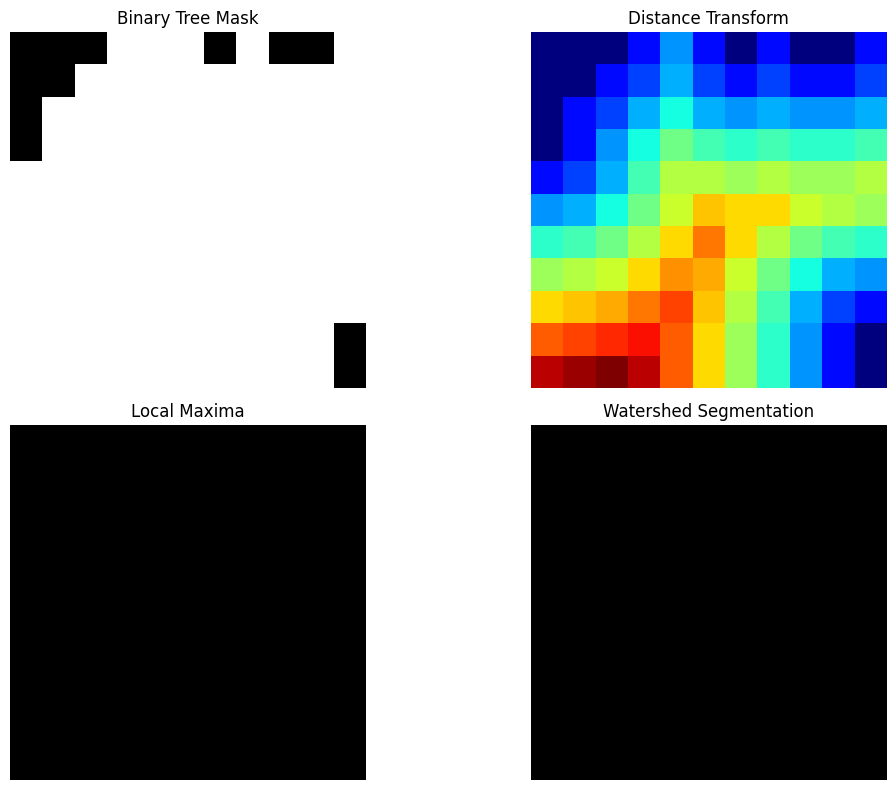

In [ ]:
# Use ROI from drawn polygon
region = map1.user_roi

# Define date range for the last 30 days
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
print("Start date:", start_str)
print("End date:", end_str)

# Load Sentinel-2 Surface Reflectance image collection within ROI and date range
collection = (ee.ImageCollection('COPERNICUS/S2_SR')
              .filterBounds(region)
              .filterDate(start_str, end_str)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
              .select(['B4', 'B8']))  # Red = B4, NIR = B8

collection_size = collection.size().getInfo()
print("Collection size (30 days):", collection_size)
if collection_size == 0:
    raise ValueError("No images found in the last 30 days for this region. Try adjusting the date range or cloud filter.")

# Create a median composite image to reduce noise and clouds
image = collection.median()

# Compute NDVI: (NIR - RED) / (NIR + RED)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Threshold NDVI to create a binary vegetation (tree) mask (threshold can be tuned)
ndvi_threshold = 0.3
tree_mask = ndvi.gt(ndvi_threshold)

# Apply morphological filtering to smooth the mask (optional)
filtered_mask = tree_mask.focal_max(radius=1)

# --- Export the Mask to a NumPy Array ---
# Convert the filtered mask from EE to a numpy array using geemap.ee_to_numpy
mask_array = geemap.ee_to_numpy(filtered_mask, region=region, scale=10)

# Normalize mask_array: ensure binary (0 or 255) for segmentation
import numpy as np
mask_array = (mask_array > 0.5).astype(np.uint8) * 255

# Remove extra dimension if exists (squeeze)
mask_array = np.squeeze(mask_array)
print("mask_array shape:", mask_array.shape)

# --- Watershed Segmentation using OpenCV and skimage ---
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

# Compute the distance transform of the binary mask
distance = cv2.distanceTransform(mask_array, cv2.DIST_L2, 5)

# Find local maxima as coordinates; note: parameter 'indices' is not used.
coords = peak_local_max(distance, min_distance=20, labels=mask_array)

# Create a boolean mask for local maxima
localMax = np.zeros(distance.shape, dtype=bool)
if coords.size > 0:
    localMax[tuple(coords.T)] = True

# Label the markers
markers = cv2.connectedComponents(np.uint8(localMax))[1]

# Apply the watershed algorithm; use negative distance so that peaks become basins
labels = watershed(-distance, markers, mask=mask_array)

# Count the number of segments (trees): ignore background (label 0)
num_trees = np.max(labels)
print("Estimated number of trees (via watershed segmentation):", num_trees)

# --- Visualization ---
plt.figure(figsize=(12, 8))

# Original binary mask
plt.subplot(2, 2, 1)
plt.imshow(mask_array, cmap='gray')
plt.title('Binary Tree Mask')
plt.axis('off')

# Distance transform visualization
plt.subplot(2, 2, 2)
plt.imshow(distance, cmap='jet')
plt.title('Distance Transform')
plt.axis('off')

# Markers for watershed (local maxima)
plt.subplot(2, 2, 3)
plt.imshow(localMax, cmap='nipy_spectral')
plt.title('Local Maxima')
plt.axis('off')

# Watershed segmentation result
plt.subplot(2, 2, 4)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Watershed Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Install necessary packages (run this cell if not already installed)
!pip install geemap earthengine-api opencv-python-headless

# Import required libraries
import ee
import geemap
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Step 1: Authenticate and initialize Earth Engine in Colab.
# Follow the authentication link that appears.
ee.Authenticate()
ee.Initialize()

# Define the Area of Interest (AOI)
aoi = ee.Geometry.Point([100.1, 15.7])

# Retrieve a Sentinel-2 image from the collection using filters for AOI, date, and cloud cover.
image = (ee.ImageCollection('COPERNICUS/S2')
         .filterBounds(aoi)
         .filterDate('2020-01-01', '2020-12-31')
         .sort('CLOUDY_PIXEL_PERCENTAGE')
         .first())

# Select the near-infrared band (B8) useful for vegetation analysis.
band = image.select('B8')

# Define visualization parameters.
vis_params = {'min': 0, 'max': 3000, 'palette': ['black', 'green']}

# Create an interactive geemap map and add the Sentinel-2 layer.
Map = geemap.Map(center=[15.7, 100.1], zoom=12)
Map.addLayer(image, vis_params, 'Sentinel-2')
Map.add_basemap('SATELLITE')
Map  # In Colab, this will display the interactive map widget.

# Step 2: Export the image thumbnail to a numpy array.
# Define the region to export (buffered around the AOI).
region = aoi.buffer(500).bounds().getInfo()['coordinates']
thumb_params = {'region': region, 'dimensions': 512, 'format': 'png'}
thumb_url = band.getThumbURL(thumb_params)

# Download the thumbnail image from the generated URL.
resp = urllib.request.urlopen(thumb_url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
cv_image = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)

# Process the image with OpenCV:
# 1. Apply Gaussian blur to reduce noise.
blurred = cv2.GaussianBlur(cv_image, (5, 5), 0)

# 2. Apply thresholding to create a binary image for segmentation.
_, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

# 3. Use morphological opening to remove noise and separate touching objects.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 4. Count the connected components (assumed to represent trees).
num_labels, labels_im = cv2.connectedComponents(opened)
tree_count = num_labels - 1  # Subtract one to discount the background.

print("Estimated number of trees:", tree_count)

# Visualize the original and segmented images side by side.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale Image")
plt.imshow(cv_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(opened, cmap='gray')
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [ ]:
# --- Earth Engine & geemap Setup ---
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # For displaying OpenCV images in Colab

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')
display(map1)  # Display the map in Colab

# --- Wait for user to draw an ROI ---
print("Draw a region of interest (ROI) on the map and then run the next cell.")



Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Draw a region of interest (ROI) on the map and then run the next cell.


Download URL for ROI image: https://earthengine.googleapis.com/v1/projects/ee-sahacstu/thumbnails/4311cc07e1ea23c1a9118055592ce67a-6850486fa5a09f8efd6290cf53b11571:getPixels


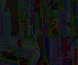

ROI image stored in 'roi_image' variable for OpenCV processing.


In [ ]:
# Function to capture the drawn ROI
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("No ROI found! Please draw a region on the map.")
        return None
    return features[0].geometry()  # FIX: Use .geometry() to get the geometry

# Extract the drawn ROI
roi_geojson = get_roi()

if roi_geojson:
    # Convert to Earth Engine Geometry
    roi = ee.Geometry(roi_geojson)  # This now works properly

    # Select an Earth Engine Image (e.g., Sentinel-2)
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()  # Select the least cloudy image

    # Clip the image to the ROI
    clipped_image = image.clip(roi)

    # Select RGB bands
    rgb_image = clipped_image.select(['B4', 'B3', 'B2'])  # Red, Green, Blue

    # Convert to an array and download
    url = rgb_image.getDownloadURL({'scale': 10, 'region': roi})
    print("Download URL for ROI image:", url)

    # Use geemap to convert the image to a NumPy array
    np_image = geemap.ee_to_numpy(rgb_image, region=roi)

    if np_image is not None:
        # Convert to OpenCV format (uint8)
        np_image = np.uint8(255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image)))

        # Convert from (H, W, C) to (C, H, W) if needed
        np_image = np_image[:, :, :3]  # Ensure only 3 channels (RGB)

        # Display the image using OpenCV
        cv2_imshow(cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR))

        # Store the image for further processing in OpenCV
        roi_image = np_image  # This variable contains the processed ROI image
        print("ROI image stored in 'roi_image' variable for OpenCV processing.")
    else:
        print("Failed to download image.")

else:
    print("No ROI selected. Please draw an ROI and run the cell again.")


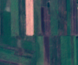

✅ Cropped satellite image stored in 'roi_image' for OpenCV processing.


In [ ]:
# Function to capture the drawn ROI
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # Select Sentinel-2 image, filter for cloud-free imagery
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # Clip the image to the ROI
    cropped_image = image.clip(roi)

    # Select RGB bands (Sentinel-2: B4 = Red, B3 = Green, B2 = Blue)
    rgb_image = cropped_image.select(['B4', 'B3', 'B2'])

    # Convert to NumPy Array
    np_image = geemap.ee_to_numpy(rgb_image, region=roi)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Ensure it has 3 channels (RGB)
        np_image = np_image[:, :, :3]

        # Convert RGB to BGR for OpenCV display
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # Display using OpenCV
        cv2_imshow(np_image_bgr)

        # Store image for further processing
        roi_image = np_image_bgr
        print("✅ Cropped satellite image stored in 'roi_image' for OpenCV processing.")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")


In [ ]:
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Display OpenCV images in Colab

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map with Google Satellite Basemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=16)  # Default zoom (adjusts later)
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')  # ✅ Google Satellite Basemap
display(map1)

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
!pip install geemap folium opencv-python numpy requests


In [ ]:
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Display OpenCV images in Colab

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map with Google Satellite Basemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=15)  # Increase zoom for more details
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')  # ✅ This is Google Satellite View
display(map1)

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Display OpenCV images in Colab

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map with a Google Maps-style basemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=15)  # Adjust zoom level for better details
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('HYBRID')  # ✅ Hybrid basemap (Satellite + Roads)
display(map1)

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
# Function to get drawn ROI
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())

# Extract ROI
roi = get_roi()

if roi:
    # ✅ Use a high-resolution dataset (NAIP or Dynamic World)
    # NAIP: High-Resolution (1m) Aerial Imagery (USA ONLY)
    image = ee.ImageCollection("USDA/NAIP/DOQQ") \
        .filterBounds(roi) \
        .sort("system:time_start") \
        .first()

    # Alternative: Dynamic World (Global Satellite Image)
    # image = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
    #     .filterBounds(roi) \
    #     .first()

    # Clip the image to the ROI
    cropped_image = image.clip(roi)

    # Convert to NumPy Array
    np_image = geemap.ee_to_numpy(cropped_image, region=roi)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Convert to OpenCV BGR format
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # Display using OpenCV
        cv2_imshow(np_image_bgr)

        # Store image for further processing
        roi_image = np_image_bgr
        print("✅ High-resolution satellite image stored in 'roi_image' for OpenCV processing.")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")




KeyboardInterrupt: 

In [ ]:
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Display OpenCV images in Colab

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map with Google Satellite Basemap
map1 = geemap.Map(center=[15.7, 100.1], zoom=15)  # Increase zoom for more details
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')  # ✅ This is Google Satellite View
display(map1)

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
# Function to get drawn ROI
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())

# Extract ROI
roi = get_roi()

if roi:
    # Use Google Maps Basemap (High-Resolution Satellite View)
    google_satellite = ee.Image("GOOGLE/SATELLITE")

    # Clip the image to the ROI
    cropped_image = google_satellite.clip(roi)

    # Convert to NumPy Array
    np_image = geemap.ee_to_numpy(cropped_image, region=roi)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Convert to OpenCV BGR format
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # Display using OpenCV
        cv2_imshow(np_image_bgr)

        # Store image for further processing
        roi_image = np_image_bgr
        print("✅ Google Satellite cropped image stored in 'roi_image' for OpenCV processing.")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")


Exception: Image.load: Image asset 'GOOGLE/SATELLITE' not found (does not exist or caller does not have access).

In [ ]:
import ee
import geemap
from IPython.display import display  # Ensure correct import
import PIL.Image
import IPython.display as display  # Avoid module override

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')

# Show the interactive map (Colab Fix)
map1  # Works without `display()`

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
# Set a high-resolution output (Full HD or 4K)
screenshot_path = "/mnt/data/high_res_map.png"

# Capture the map as an image with custom resolution
map1.screenshot(screenshot_path, width=3840, height=2160)  # 4K resolution

# Load and display the image
img = PIL.Image.open(screenshot_path)
display.display(img)

print(f"✅ High-resolution map saved at: {screenshot_path}")


AttributeError: 'Map' object has no attribute 'screenshot'

In [ ]:
import ee
import geemap
from IPython.display import display  # Ensure correct import

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# Create an interactive map
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)
map1.addLayerControl()
map1.add_draw_control()
map1.add_basemap('SATELLITE')

# **Force Map Display**
map1  # Works in Google Colab (No need for display(map1))

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")



✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
# Set a high-resolution output (Full HD or 4K)
screenshot_path = "/mnt/data/high_res_map.png"

# Capture the map as an image with custom resolution
map1.screenshot(screenshot_path, width=3840, height=2160)  # 4K resolution

# Load and display the image
img = PIL.Image.open(screenshot_path)
display.display(img)

print(f"✅ High-resolution map saved at: {screenshot_path}")


AttributeError: 'Map' object has no attribute 'screenshot'

In [ ]:
# --- Import Required Libraries ---
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # OpenCV display in Colab
from IPython.display import display
import PIL.Image

# --- Authenticate & Initialize Earth Engine ---
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# --- Create an Interactive Map ---
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)  # Set center and zoom
map1.addLayerControl()
map1.add_draw_control()  # Allow drawing of ROI
map1.add_basemap('SATELLITE')  # Use a satellite basemap

# **Fix: Properly Display the Map in Google Colab**
map1  # This forces display in Colab

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
map1

Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Function to capture the drawn ROI from the interactive map
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # --- Select Cloud-Free Sentinel-2 Image ---
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # --- Clip the Image to the ROI ---
    cropped_image = image.clip(roi)

    # --- Select RGB Bands (Sentinel-2: B4 = Red, B3 = Green, B2 = Blue) ---
    rgb_image = cropped_image.select(['B4', 'B3', 'B2'])

    # --- Convert to NumPy Array for OpenCV Processing ---
    np_image = geemap.ee_to_numpy(rgb_image, region=roi)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Ensure it has 3 channels (RGB)
        np_image = np_image[:, :, :3]

        # Convert RGB to BGR for OpenCV display
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # Display using OpenCV
        cv2_imshow(np_image_bgr)

        # Store image for further processing
        roi_image = np_image_bgr
        print("✅ Cropped satellite image stored in 'roi_image' for OpenCV processing.")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")


✅ Cropped satellite image stored in 'roi_image' for OpenCV processing.


In [ ]:
# Function to capture the drawn ROI from the interactive map
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # --- Select Cloud-Free Sentinel-2 Image ---
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # --- Clip the Image to the ROI ---
    cropped_image = image.clip(roi)

    # --- Select RGB Bands (Sentinel-2: B4 = Red, B3


In [ ]:
cropped_image

In [ ]:
# Function to capture the drawn ROI from the interactive map
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # --- Select Cloud-Free Sentinel-2 Image ---
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # --- Clip the Image to the ROI ---
    cropped_image = image.clip(roi)

    # --- Select RGB Bands (Sentinel-2: B4 = Red, B3 = Green, B2 = Blue) ---
    rgb_image = cropped_image.select(['B4', 'B3', 'B2'])

    # --- Convert to NumPy Array for OpenCV Processing ---
    np_image = geemap.ee_to_numpy(rgb_image, region=roi)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Ensure it has 3 channels (RGB)
        np_image = np_image[:, :, :3]

        # Convert RGB to BGR for OpenCV display
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # **Save Cropped Image to File**
        cropped_image_path = "/mnt/data/cropped_satellite_image.png"
        cv2.imwrite(cropped_image_path, np_image_bgr)

        # Display the cropped image
        cv2_imshow(np_image_bgr)

        print(f"✅ Cropped satellite image saved at: {cropped_image_path}")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")


✅ Cropped satellite image saved at: /mnt/data/cropped_satellite_image.png


In [ ]:
 cv2_imshow(np_image_bgr)


In [ ]:
# --- Import Required Libraries ---
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # OpenCV display in Colab
from IPython.display import display
import PIL.Image

# --- Authenticate & Initialize Earth Engine ---
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# --- Create an Interactive Map ---
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)  # Set center and zoom
map1.addLayerControl()
map1.add_draw_control()  # Allow drawing of ROI
map1.add_basemap('SATELLITE')  # Use a satellite basemap

# **Fix: Properly Display the Map in Google Colab**
map1  # This forces display in Colab

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
map1

Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

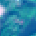

✅ High-resolution cropped satellite image saved at: /mnt/data/high_res_cropped_satellite.png


In [ ]:
# Function to capture the drawn ROI from the interactive map
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # --- Select Cloud-Free Sentinel-2 Image ---
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # --- Clip the Image to the ROI ---
    cropped_image = image.clip(roi)

    # --- Select RGB Bands (Sentinel-2: B4 = Red, B3 = Green, B2 = Blue) ---
    rgb_image = cropped_image.select(['B4', 'B3', 'B2'])

    # --- Convert to High-Resolution NumPy Array ---
    np_image = geemap.ee_to_numpy(rgb_image, region=roi, scale=5)  # Set high resolution (5m per pixel)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Ensure it has 3 channels (RGB)
        np_image = np_image[:, :, :3]

        # Convert RGB to BGR for OpenCV display
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # **Save High-Resolution Cropped Image to File**
        cropped_image_path = "/mnt/data/high_res_cropped_satellite.png"
        cv2.imwrite(cropped_image_path, np_image_bgr)

        # Display the high-resolution cropped image
        cv2_imshow(np_image_bgr)

        print(f"✅ High-resolution cropped satellite image saved at: {cropped_image_path}")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")


In [ ]:
# --- Import Required Libraries ---
import ee
import geemap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # OpenCV display in Colab
from IPython.display import display
import PIL.Image

# --- Authenticate & Initialize Earth Engine ---
ee.Authenticate()
ee.Initialize(project='ee-sahacstu')

# --- Create an Interactive Map ---
map1 = geemap.Map(center=[15.7, 100.1], zoom=12)  # Set center and zoom
map1.addLayerControl()
map1.add_draw_control()  # Allow drawing of ROI
map1.add_basemap('SATELLITE')  # Use a satellite basemap

# **Fix: Properly Display the Map in Google Colab**
map1  # This forces display in Colab

print("✅ Draw a region of interest (ROI) on the map and then run the next cell.")


✅ Draw a region of interest (ROI) on the map and then run the next cell.


In [ ]:
map1

Map(center=[15.7, 100.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

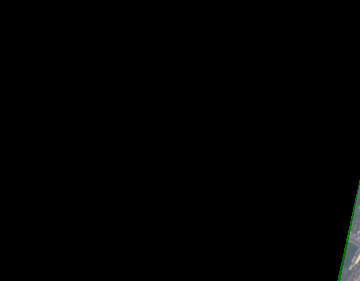

✅ High-resolution cropped satellite image saved at: /mnt/data/high_res_cropped_satellite.png
✅ Image Size: 360 x 281 pixels


In [ ]:
# Function to capture the drawn ROI from the interactive map
def get_roi():
    features = map1.draw_features
    if len(features) == 0:
        print("❌ No ROI found! Please draw a region on the map.")
        return None
    return ee.Geometry(features[0].geometry())  # Convert Feature to Geometry

# Extract the drawn ROI
roi = get_roi()

if roi:
    # --- Select Cloud-Free Sentinel-2 Image ---
    image = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # --- Clip the Image to the ROI ---
    cropped_image = image.clip(roi)

    # --- Select RGB Bands (Sentinel-2: B4 = Red, B3 = Green, B2 = Blue) ---
    rgb_image = cropped_image.select(['B4', 'B3', 'B2'])

    # --- Increase Image Resolution ---
    scale_value = 10  # Use 10m per pixel (default Sentinel-2 resolution)
    np_image = geemap.ee_to_numpy(rgb_image, region=roi, scale=scale_value)

    if np_image is not None:
        # Normalize and scale to 8-bit for OpenCV
        np_image = np_image.astype(np.float32)
        np_image = 255 * (np_image - np.min(np_image)) / (np.max(np_image) - np.min(np_image))
        np_image = np.uint8(np_image)

        # Ensure it has 3 channels (RGB)
        np_image = np_image[:, :, :3]

        # Convert RGB to BGR for OpenCV display
        np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

        # **Save High-Resolution Cropped Image to File**
        cropped_image_path = "/mnt/data/high_res_cropped_satellite.png"
        cv2.imwrite(cropped_image_path, np_image_bgr)

        # Display the high-resolution cropped image
        cv2_imshow(np_image_bgr)

        print(f"✅ High-resolution cropped satellite image saved at: {cropped_image_path}")
        print(f"✅ Image Size: {np_image.shape[1]} x {np_image.shape[0]} pixels")
    else:
        print("❌ Failed to retrieve image. Try a different location or dataset.")
else:
    print("❌ No ROI selected. Please draw an ROI and run the cell again.")
